SGD Regressor offers a lot of control over optimization procedure 

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(306)

shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [3]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

dev part will be used for hyperparameter tuning 

In [4]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

### Baseline SGDRegressor

* STEP 1: Instantiate baseline SGDRegressor with default parameters.
* STEP 2: Train the model with training feature matrix and labels.
* STEP 3: Obtain the score on the train and dev data

In [5]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  309190327803747.2
Mean Absolute Error on development set:  311959782899622.1


### Adding a feature scaling step

SGD is sensitive to feature scaling so we do scaling

In [6]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor())])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  0.5135804404077051
Mean Absolute Error on development set:  0.6373131245753217


As we can see that the error has reduced drastically 

### Step-wise training of SGDRegressor

* STEP 1: Instantiate SGDRegressor with warm_start=True and tol=-np.infty
* STEP 2: Train SGD step by step and recod regression loss in each step.
* STEP 3: Plot learning curve and see if there are any issues in training.

Text(0.5, 1.0, 'Learning curve: eta0= 0.0100')

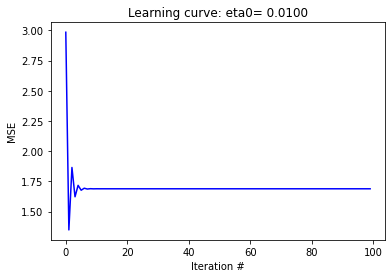

In [12]:
eta0 = 1e-2 # default 
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=1, tol=-np.infty,
                                                warm_start=True,
                                                random_state=42))])

loss = []

for epoch in range(100):
    """
    warm_start = True 
    --> it uses param values that were learned in the prev itr 
    and update those values in the fit function 
    """
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0: .4f}')

The loss reduced intially and then increased. This could be due to large training rates. We will reduce the rate by a factor of 10 and repeat the process.

Text(0.5, 1.0, 'Learning curve: eta0= 0.0010')

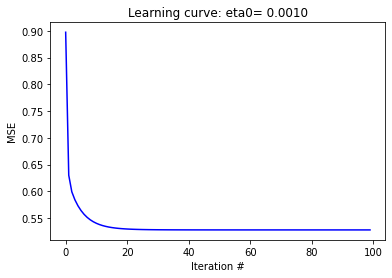

In [13]:
# optimal learning rate 
eta0 = 1e-3
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=1, tol=-np.infty,
                                                warm_start=True, eta0=eta0,
                                                random_state=42))])

loss = []

for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0: .4f}')

we get an expected learning curve. but still the loss is not 0 this could be because of underfitting 

Text(0.5, 1.0, 'Learning curve: eta0= 0.0001')

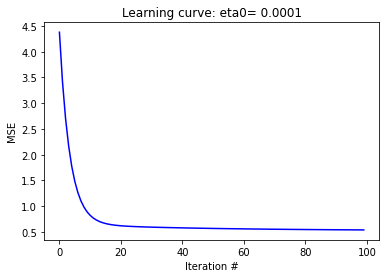

In [14]:
# moderately small learning rate 
eta0 = 1e-4
sgd_pipeline_ms = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=1, tol=-np.infty,
                                                warm_start=True, eta0=eta0,
                                                random_state=42))])

loss = []

for epoch in range(100):
    sgd_pipeline_ms.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline_ms.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0: .4f}')

Text(0.5, 1.0, 'Learning curve: eta0= 0.0000')

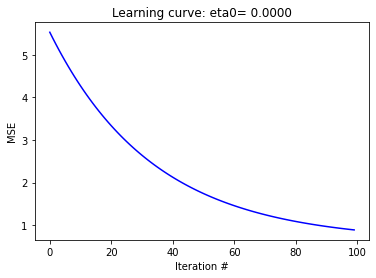

In [15]:
# very small learning rate 
eta0 = 1e-5
sgd_pipeline_vs = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=1, tol=-np.infty,
                                                warm_start=True, eta0=eta0,
                                                random_state=42))])

loss = []

for epoch in range(100):
    sgd_pipeline_vs.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline_vs.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0: .4f}')

for very small learning rate as we can see that the loss reduces very slowly and not yet reached to the global minima. We can increase the num of epoch to give it more space to converge or try giving further smaller learning rate 

In [16]:
print('# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)


# iteration before reaching convergence criteria:  1
#Weight updated: 11611.0


In [20]:
len(train_features) + 1 # num of weight updates 

11611

In [21]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  0.5333732983042573
Mean Absolute Error on development set:  0.5190150280908042


### Fixing learning rate through validation curves

* STEP 1: Provide the list of values to be tried for a hyper=parameter.
* STEP 2: Instantiate an object of validation_curve with estimator, training features and label. Set scoring parameter to relevant score.
* STEP 3: Convert sccores to error.
* STEP 4: Fix the hyper parameter value where the test error is the least.

In [22]:
%%time

eta0 = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, 
    param_name="sgd__eta0", param_range=eta0, cv = shuffle_split_cv, 
    scoring="neg_mean_squared_error", n_jobs=2
)

train_errors, test_errors = -train_scores, -test_scores

CPU times: total: 93.8 ms
Wall time: 4.24 s


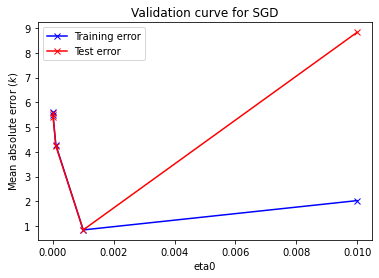

In [23]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label='Training error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label='Test error')
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean absolute error ($k$)")
_ = plt.title("Validation curve for SGD")

* Training and test error reduced initially but beyond a point it just shot up. 
* So the third point is the optimal point 
> NOTE : for values more than 1e-1 you will get simialr curve and the loss will be so high that 1e-2 might seem the right choice. <br> So we should not go beyond 1e-2 usually.
> * For 1st and second point the change in loss is insignificant so we should not go beyond 1e-5 as well

Text(0.5, 1.0, 'Validation curve for SGD')

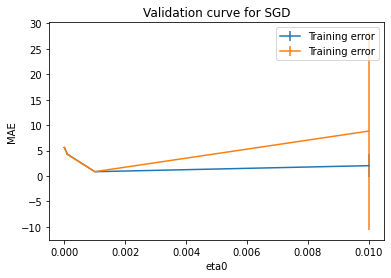

In [24]:
plt.errorbar(eta0, train_errors.mean(axis = 1), 
            yerr=train_errors.std(axis=1),
            label = 'Training error')
plt.errorbar(eta0, test_errors.mean(axis = 1), 
            yerr=test_errors.std(axis=1),
            label = 'Training error')

plt.legend()
plt.xlabel('eta0')
plt.ylabel('MAE')
plt.title('Validation curve for SGD')

if we plot the sd of error we can see that at the end the sd is too high this might lead to unstable prediction

### SGDRegressor

In [25]:
# avg sgd 
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            validation_fraction=0.2, # for early stopping 
                                            n_iter_no_change=5,
                                            average=10, # will start avging SGD after it sees 10 samples 
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  0.579376454514559
Mean Absolute Error on development set:  0.5689180241137523


In [28]:

print('# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

# iteration before reaching convergence criteria:  7
#Weight updated: 81271.0


In [27]:
len(train_features) * 7 + 1 # num of weight updates

81271

In [29]:
#learning rate changed to constant from inverse scaling(default)

# eta0 = 1e-3 will be used accross all itr 
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            learning_rate='constant', # default inv_scaling
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

print('\n# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

Mean Absolute Error on Training set:  0.5359339681114987
Mean Absolute Error on development set:  0.5151099728924144

# iteration before reaching convergence criteria:  8
#Weight updated: 92881.0


In [33]:
#learning rate changed to adaptive from inverse scaling(default)

# in adaptive learning rate it uses the initial learning rate as long as it reaches the conv criteria
# as the conv criteria is made it reduces the learning rate /5 and again continues till convergence 
# it will continue until the lr drops below 1e-6
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            learning_rate='adaptive',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

print('\n# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

Mean Absolute Error on Training set:  0.5340193046836148
Mean Absolute Error on development set:  0.5198356196858102

# iteration before reaching convergence criteria:  33
#Weight updated: 383131.0


#### Setting max_iters

imperically SGD converges after seeing about 1 million examples 

In [34]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [37]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=max_iter,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

print('\n# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

Mean Absolute Error on Training set:  0.5359339681114987
Mean Absolute Error on development set:  0.5151099728924144

# iteration before reaching convergence criteria:  8
#Weight updated: 92881.0


even though max_itr is 65 but SGD converges after 8 itr 